<a href="https://colab.research.google.com/github/climate-and-health-datasci-Unicamp/ldl-cholesterol-climate-analysis/blob/master/notebooks/03_LDL_above_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Authors:**
* [Júlia Perassolli De Lázari](https://github.com/juliaplazari)
* [Thiago Ribas Bella](https://github.com/trbella)

*created in jun/2020*

#LDL level above average

* INPUT: [ldl_waves_lags.csv](https://drive.google.com/file/d/1A2VRn4hrQ3oYkl7tG80mJtLt4qoK48Of/view?usp=sharing)


## Read data

In [1]:
#@title Import libraries and load data
#-------------------------------------------------------------------#
#                       Import libraries                            #
#-------------------------------------------------------------------#
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#-------------------------------------------------------------------#
#          Load dataframe with cold waves and lags                  #
#-------------------------------------------------------------------#
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#id obtained from shareable link in gdrive file
googl = drive.CreateFile({'id':'1A2VRn4hrQ3oYkl7tG80mJtLt4qoK48Of'})
googl.GetContentFile('ldl_waves_lags.csv')

df_shift = pd.read_csv('/content/ldl_waves_lags.csv')
print("Lenght of dataframe:",len(df_shift))
df_shift.sort_values(by = 'DATE').head()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Lenght of dataframe: 980046


,Unnamed: 0,DATE,Result,Age,Age group,Sex,below_pct,CW,cwave,ci,cf,above_pct,HW,hwave,hi,hf,bool,CI_lag0,HI_lag0,CI_lag1,HI_lag1,CI_lag2,HI_lag2,CI_lag3,HI_lag3,CI_lag4,HI_lag4,CI_lag5,HI_lag5,CI_lag6,HI_lag6,CI_lag7,HI_lag7,CI_lag8,HI_lag8,CI_lag9,HI_lag9,CI_lag10,HI_lag10
395,395,2008-03-03,104.0,64,5 - Adult,F,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
479,479,2008-03-03,60.0,34,4 - Young adult,M,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
480,480,2008-03-03,205.0,56,5 - Adult,F,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
481,481,2008-03-03,125.0,45,5 - Adult,F,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
482,482,2008-03-03,128.0,60,5 - Adult,F,0,0,0,0,0,0,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Outlier removal

In [2]:
#@title Remove data from extremes 5% and 95%
#remove outliers - data from extremes 5% and 95%

df_shift = df_shift[(df_shift['Result']<=df_shift['Result'].quantile(.95))&(df_shift['Result']>=df_shift['Result'].quantile(.05))]
print("After removing the 5% and 95% extremes we have",len(df_shift),"rows")                                          

After removing the 5% and 95% extremes we have 884246 rows


## Age and sex stratification


In [13]:
#@title create subsets for stratification

#create subsets
print('stratified subsets and its sample size\n')
under_20_F = df_shift[(df_shift['Age'] < 20) & (df_shift['Sex']=="F")]
print("Under 20 female:",len(under_20_F))
under_20_M = df_shift[(df_shift['Age'] < 20) & (df_shift['Sex']=="M")]
print("Under 20 male:",len(under_20_M))
between_20_65_F = df_shift[(df_shift['Age'] >= 20) & (df_shift['Age'] < 65)  & (df_shift['Sex']=="F")]
print("Between 20 and 65 female:",len(between_20_65_F))
between_20_65_M = df_shift[(df_shift['Age'] >= 20) & (df_shift['Age'] < 65) & (df_shift['Sex']=="M")]   
print("Between 20 and 65 female:",len(between_20_65_M))
over_65_F = df_shift[(df_shift['Age'] > 64) & (df_shift['Sex']=="F")]   
print("Over 65 female:",len(over_65_F))
over_65_M = df_shift[(df_shift['Age'] > 64) & (df_shift['Sex']=="M")]   
print("Over 65 male:",len(over_65_M))                                                                                                                                        

dataframes = [under_20_F,under_20_M,between_20_65_F,between_20_65_M,over_65_F,over_65_M]
df_names = ["Under 20 female", "Under 20 male", "Between 20 and 65 female", "Between 20 and 65 male","Over 65 female", "Over 65 male"]     

stratified subsets and its sample size

Under 20 female: 41529
Under 20 male: 35392
Between 20 and 65 female: 352335
Between 20 and 65 female: 249457
Over 65 female: 115768
Over 65 male: 89765


### Install TableOne package

In [4]:
pip install tableone

## Check if the Standard Mean Deviation (SMD) table has values higher than 0.1. If we find, it means there is a variable with unbalanced data

We can observe that maximum SMD found between groups (cold, control and heat) is 0.0365 for Sex variable. Thus, we conclude the data in each variable is balanced between groups, for example, same number of female in each group.

In the example table we can see data distribution for Age and Sex variables for **All data** in lag 10.

In [5]:
#@title SMD max between treatments (0: cold, 1: control, 2: heat)
from tableone import TableOne

teste = df_shift
lags = list(range( 0, 11, 1))
smd = pd.DataFrame()
for i in lags:    
    conditions = [
    (teste[f'CI_lag{i}']==1),
    (teste[f'HI_lag{i}']==1),
    (teste['cwave']==0)&(teste['hwave']==0)&(teste['below_pct']==0)&(teste['above_pct']==0)]
    #0: cold, 1: control, 2: heat
    choices = [0, 2, 1]
    teste['treatment'] = np.select(conditions, choices)
    mytable = TableOne(data = teste, columns=['Sex','Age'],categorical=['Sex'],smd=True,groupby=['treatment'])
    temp_sm = pd.DataFrame(mytable.smd_table)
    temp_sm['LAG'] = f'lag{i}'
    smd = smd.append(temp_sm)
print(f'EXAMPLE TABLE - ALL DATA\nSex and Age variables for lag{i} (Cold vs Heat)\n', mytable)

EXAMPLE TABLE - ALL DATA
Sex and Age variables for lag10 (Cold vs Heat)
                  Grouped by treatment                                                                                        
                              Missing        Overall              0              1            2 SMD (0,1) SMD (0,2) SMD (1,2)
n                                             884246         480396         397595         6255                              
Sex, n (%)     F                    0  509632 (57.6)  277411 (57.7)  228656 (57.5)  3565 (57.0)     0.005     0.015     0.010
               M                       374614 (42.4)  202985 (42.3)  168939 (42.5)  2690 (43.0)                              
Age, mean (SD)                      0    50.0 (18.9)    50.1 (18.8)    50.0 (18.9)  50.3 (18.8)    -0.002     0.013     0.016
[1] Hartigan's Dip Test reports possible
                                  multimodal distributions for: Age.
[2] Normality test reports non-normal
                       

In [6]:
#@title Table with the highest SMD value between groups
print('Highest SMD between groups\n')
print('COLD vs CONTROL\n',smd['SMD (0,1)'][smd['SMD (0,1)'] == smd['SMD (0,1)'].max()],'\n\n')
print('COLD vs HEAT\n',smd['SMD (0,2)'][smd['SMD (0,2)'] == smd['SMD (0,2)'].max()],'\n\n')
print('CONTROL vs HEAT\n',smd['SMD (1,2)'][smd['SMD (1,2)'] == smd['SMD (1,2)'].max()])


Highest SMD between groups

COLD vs CONTROL
 variable
Sex    0.00478685
Name: SMD (0,1), dtype: object 


COLD vs HEAT
 variable
Sex    0.0344452
Name: SMD (0,2), dtype: object 


CONTROL vs HEAT
 variable
Sex    0.0387298
Name: SMD (1,2), dtype: object


# **Analysis for ldl levels above reference value**

### **LDL cholesterol levels distribution: cold wave vs control days**
### *No Stratification*
Data were lagged from 0 to 10 days after the beginning of the cold spell

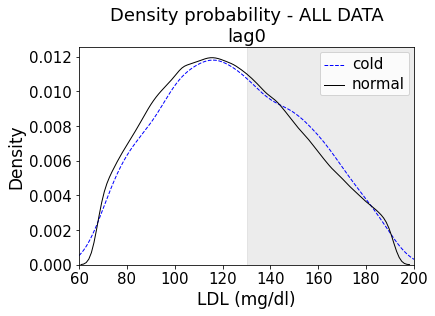

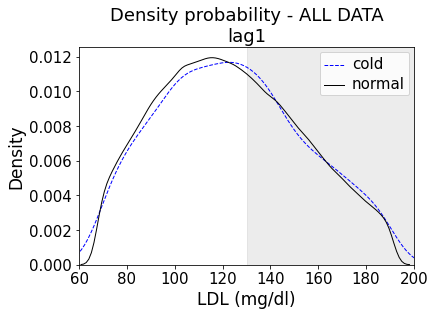

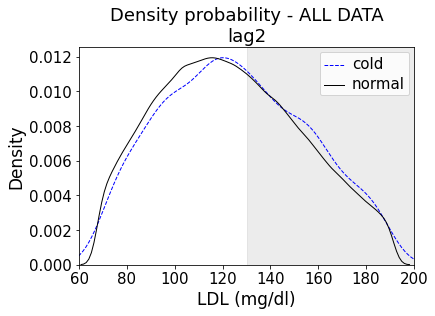

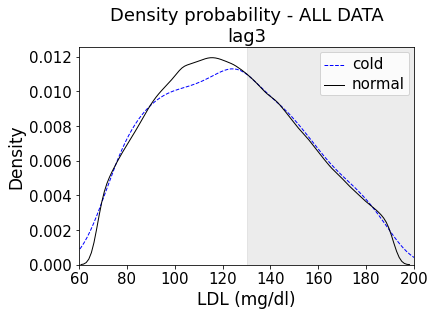

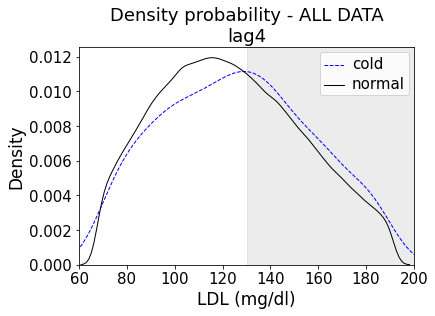

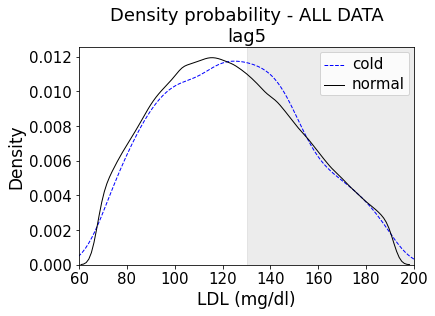

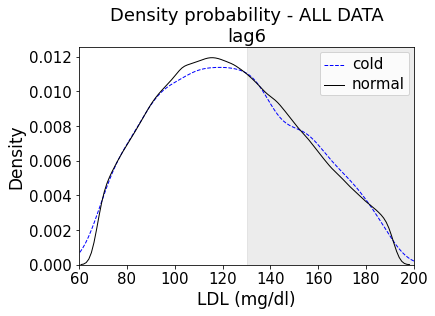

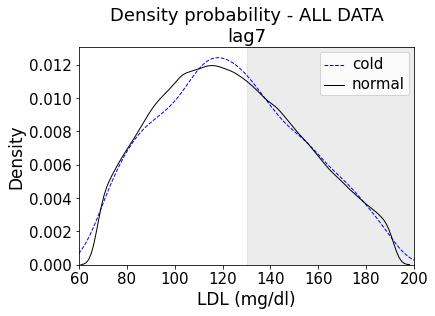

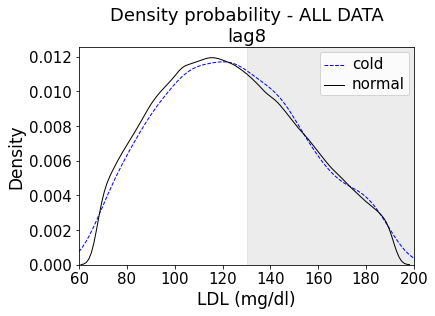

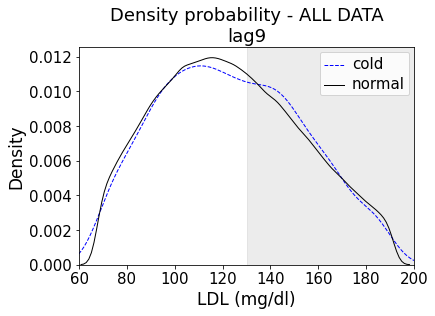

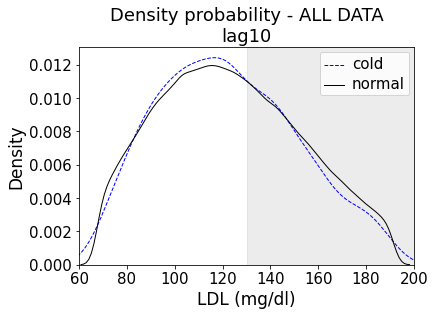

,LAG,Cold spell,Normal,Diff %,p_value,Sig.
0,0,42.38,40.17,2.22,0.005699,**
1,1,41.23,40.17,1.06,0.223848,-
2,2,42.76,40.17,2.59,0.001547,**
3,3,41.15,40.17,0.98,0.764419,-
4,4,44.76,40.17,4.59,0.003874,**
5,5,42.21,40.17,2.05,0.083296,-
6,6,40.36,40.17,0.19,0.864246,-
7,7,40.25,40.17,0.08,0.615661,-
8,8,41.24,40.17,1.08,0.301167,-
9,9,41.40,40.17,1.23,0.475953,-


In [7]:
#@title Graphs
#-------------------------------------------------------------------#
#                          Probability                              #
#-------------------------------------------------------------------#
lags = list(range( 0, 11, 1))
prob = pd.DataFrame()
lag = []
cold_spell = []
normal = []
sig =[]
mw = []
dif = []
for i in lags:     
    Cold_1 = pd.Series(df_shift['Result'][df_shift[f'CI_lag{i}']==1])
    Normal = pd.Series(df_shift['Result'][(df_shift['cwave']==0)&(df_shift['hwave']==0)&(df_shift['below_pct']==0)&(df_shift['above_pct']==0)])
    b = scipy.stats.mannwhitneyu(Cold_1,Normal,alternative='two-sided')[1]
    ax1 = sns.distplot(Cold_1,hist=False,kde=True,kde_kws = {'linewidth': 1}, label = 'cold',color='blue')
    x1 = ax1.get_lines()[0].get_data()[0] # Get the x data of the distribution
    y1 = ax1.get_lines()[0].get_data()[1] # Get the y data of the distribution
    [line.set_linestyle("--") for line in ax1.lines]
    ax2 = sns.distplot(Normal,hist=False,kde=True,kde_kws = {'linewidth': 1}, label = 'normal',color='black')
    x2 = ax2.get_lines()[1].get_data()[0] # Get the x data of the distribution
    y2 = ax2.get_lines()[1].get_data()[1] # Get the y data of the distribution
    
    '''
    Code for the probability calculus adapted from: https://stackoverflow.com/questions/52470172/how-to-get-possibility-distribution-function-from-python-seaborn-displot
    '''
    
    #Value to estimate for
    value = 130 #reference value
    value2 = 200 #x lim
    
    ecart = value2 - value
    idx1 = (np.abs(x1-value)).argmin()
    idx_1 = (np.abs(x1-(value+ecart))).argmin()
    
    idx2 = (np.abs(x2-value)).argmin()
    idx_2 = (np.abs(x2-(value+ecart))).argmin()
      
 
    cdf1 = scipy.integrate.cumtrapz(y1, x1, dx=1, initial=0)
    pr1 = cdf1[idx_1] - cdf1[idx1] 
    
    cdf2 = scipy.integrate.cumtrapz(y2, x2, dx=1, initial=0)
    pr2 = cdf2[idx_2] - cdf2[idx2] 
    
    plt.xlim(60,200)
    
    plt.xlabel('LDL (mg/dl)',fontsize=17)
    plt.ylabel('Density',fontsize = 17)
    plt.title(f'Density probability - ALL DATA\nlag{i}',fontsize=18)
    ax1.tick_params(labelsize=15)
    plt.setp(ax1.get_legend().get_texts(), fontsize='15')
    plt.axvspan(xmin=130.1, xmax=200,alpha = 0.15,color ='gray')
    
    plt.show()

    lag.append(i)
    cold_spell.append("{:.2f}".format(pr1*100))
    normal.append("{:.2f}".format(pr2*100))
    dif.append(round((pr1-pr2)*100,2))
    if b<=0.01:
      sig.append('**')
    elif 0.01<b<=0.05:
      sig.append('*')
    else:
      sig.append('-')
    mw.append(b)

prob['LAG'] = lag
prob['Cold spell'] = cold_spell
prob['Normal'] = normal
prob['Diff %'] = dif
prob['p_value'] = mw
prob['Sig.'] = sig
prob


**Conclusion**: In the graphs and table above we can observe there is more people with ldl levels above reference value (shaded area) under cold spells than under control days, for lags 0, 2 and 4.

It means that since the beginning of the cold spell its effects on ldl levels can last for until 4 days. In other words, the cold spell effects in ldl levels start immediately and stops 5 days after its begins.

## **LDL cholesterol levels distribution: cold wave vs control days**
### *Stratified by age and sex*

Data were lagged from 0 to 10 days after the beginning of the cold spell


In [8]:
#@title *We don't need the graphs of this code section*
#-------------------------------------------------------------------#
#                          Probability - stratified                           #
#-------------------------------------------------------------------#

#create subsets
under_20_F = df_shift[(df_shift['Age'] < 20) & (df_shift['Sex']=="F")]
print("Under 20 female:",len(under_20_F))
under_20_M = df_shift[(df_shift['Age'] < 20) & (df_shift['Sex']=="M")]
print("Under 20 male:",len(under_20_M))
between_20_65_F = df_shift[(df_shift['Age'] >= 20) & (df_shift['Age'] < 65)  & (df_shift['Sex']=="F")]
print("Between 20 and 65 female:",len(between_20_65_F))
between_20_65_M = df_shift[(df_shift['Age'] >= 20) & (df_shift['Age'] < 65) & (df_shift['Sex']=="M")]   
print("Between 20 and 65 female:",len(between_20_65_M))
over_65_F = df_shift[(df_shift['Age'] > 64) & (df_shift['Sex']=="F")]   
print("Over 65 female:",len(over_65_F))
over_65_M = df_shift[(df_shift['Age'] > 64) & (df_shift['Sex']=="M")]   
print("Over 65 male:",len(over_65_M))                                                                                                                                        

dataframes = [under_20_F,under_20_M,between_20_65_F,between_20_65_M,over_65_F,over_65_M]
df_names = ["Under 20 female", "Under 20 male", "Between 20 and 65 female", "Between 20 and 65 male","Over 65 female", "Over 65 male"]    

lags = list(range( 0, 11, 1))
prob = pd.DataFrame()
subset = []
lag = []
cold_spell = []
cold_n = []
normal = []
normal_n = []
dif = []
mw = []
sig = []
for j in range(len(dataframes)):
  for i in lags:     
    Cold_1 = pd.Series(dataframes[j]['Result'][dataframes[j][f'CI_lag{i}']==1])
    Normal = pd.Series(dataframes[j]['Result'][(dataframes[j]['cwave']==0)&(dataframes[j]['hwave']==0)&(dataframes[j]['below_pct']==0)&(dataframes[j]['above_pct']==0)])
    b = scipy.stats.mannwhitneyu(Cold_1,Normal,alternative='two-sided')[1]
    cold_n.append(len(Cold_1))
    normal_n.append(len(Normal))
    ax1 = sns.distplot(Cold_1,hist=False,kde=True,kde_kws = {'linewidth': 1}, label = 'cold',color='blue')
    x1 = ax1.get_lines()[0].get_data()[0] # Get the x data of the distribution
    y1 = ax1.get_lines()[0].get_data()[1] # Get the y data of the distribution
    
    ax2 = sns.distplot(Normal,hist=False,kde=True,kde_kws = {'linewidth': 1}, label = 'normal',color='black')
    x2 = ax2.get_lines()[1].get_data()[0] # Get the x data of the distribution
    y2 = ax2.get_lines()[1].get_data()[1] # Get the y data of the distribution
    
    '''
    Code for the probability calculus adapted from: https://stackoverflow.com/questions/52470172/how-to-get-possibility-distribution-function-from-python-seaborn-displot
    '''
    #ref value 
    if dataframes[j]['Age'].mean()<=20:
      value = 110

    else:
      value = 130


    #Value to estimate for
    value2 = 200 #x lim
    
    ecart = value2 - value
    idx1 = (np.abs(x1-value)).argmin()
    idx_1 = (np.abs(x1-(value+ecart))).argmin()
    
    idx2 = (np.abs(x2-value)).argmin()
    idx_2 = (np.abs(x2-(value+ecart))).argmin()
      
    import scipy
    cdf1 = scipy.integrate.cumtrapz(y1, x1, dx=1, initial=0)
    pr1 = cdf1[idx_1] - cdf1[idx1] 
    
    cdf2 = scipy.integrate.cumtrapz(y2, x2, dx=1, initial=0)
    pr2 = cdf2[idx_2] - cdf2[idx2] 
    
    plt.xlim(60,200)
    plt.xlabel('LDL (mg/dl)',fontsize=17)
    plt.ylabel('Density',fontsize = 17)
    plt.title(f'{df_names[j]}\nlag{i}',fontsize=18)
    ax1.tick_params(labelsize=15)
    plt.setp(ax1.get_legend().get_texts(), fontsize='15')
    plt.close()
  
    
    subset.append(f'{df_names[j]}')
    lag.append(i)
    cold_spell.append("{:.2f}".format(pr1*100))
    normal.append("{:.2f}".format(pr2*100))
    dif.append(round((pr1-pr2)*100,2))
    mw.append(round(b,3))

    if b<=0.01:
      sig.append('**')
    elif 0.01<b<=0.05:
      sig.append('*')
    else:
      sig.append('-')
    
    

prob['SUBSET'] = subset
prob['lg'] = lag
prob['Cold'] = cold_spell
prob['n1'] = cold_n
prob['Nor.'] = normal
prob['n2'] = normal_n
prob['Diff'] = dif
prob['p'] = mw
prob['Sig.'] = sig

Under 20 female: 41529
Under 20 male: 35392
Between 20 and 65 female: 352335
Between 20 and 65 female: 249457
Over 65 female: 115768
Over 65 male: 89765


## **Difference between people percentage with LDL above reference value**
## Cold spell days vs control days

#### Table columns:
* **SUBSET:** Subset name
* **lg:** Days after cold spell beginning
* **Cold:** Percentage of people with ldl level above reference value under cold spell days
* **n1:** Number of ldl tests under cold spell days
* **Nor:** Percentage of people with ldl level above reference value under control days
* **n2:** Number of ldl tests under control days
* **Diff:** Difference bewteen percentages (cold - control)
* **p:** P value of Mann-Whitney U test between exams under cold spell and control days
* **Sig.:** 
  * "-" = non significant
  * "*" = p value <0.05
  * "**" = p value <0.01


In [9]:
#@title Cold vs Control days summary table
diff_max = prob[prob['p']<0.05].sort_values(by=['SUBSET','lg'],ascending=True)
diff_min = prob[prob['p']>0.05].sort_values(by=['SUBSET','lg'],ascending=True)

print('Groups who were affected by cold spell and when\nOrdered by SUBSET and lag(ascending)\n')
print(diff_max)
diff_max

#subsetting only groups that suffered cold spell effects
print('\n\nGroups who were NOT affected by cold spell and when\nOrdered by SUBSET and lag(ascending)\n')
print(diff_min[(diff_min['SUBSET']== 'Over 65 male')|(diff_min['SUBSET']== 'Over 65 female')|(diff_min['SUBSET']== 'Between 20 and 65 female')])


Groups who were affected by cold spell and when
Ordered by SUBSET and lag(ascending)

                      SUBSET  lg   Cold   n1   Nor.      n2   Diff      p Sig.
24  Between 20 and 65 female   2  46.88  879  43.56  157878   3.32  0.004   **
44            Over 65 female   0  52.76  253  43.49   52007   9.27  0.000   **
46            Over 65 female   2  50.89  228  43.49   52007   7.39  0.016    *
51            Over 65 female   7  47.55  290  43.49   52007   4.06  0.026    *
59              Over 65 male   4  47.26   87  35.81   40448  11.45  0.025    *
2            Under 20 female   2  25.58   83  37.00   18771 -11.42  0.017    *
7            Under 20 female   7  29.57  106  37.00   18771  -7.43  0.012    *
9            Under 20 female   9  28.82   99  37.00   18771  -8.17  0.021    *


Groups who were NOT affected by cold spell and when
Ordered by SUBSET and lag(ascending)

                      SUBSET  lg   Cold    n1   Nor.      n2  Diff      p Sig.
22  Between 20 and 65 female   0


**Conclusion about the table:**
 If we consider significance level under p < 0.05, there is 4 groups affected by cold spell: 
 * **Under 20 female**
 * **Over 65 male**
 * **Over 65 female**
 * **Between 20 and 65 female**
 
But, the first and youngest group shows negative *Diff*, indicating cold spells lower their ldl levels.

Unregarding results with negative *Diff* we have 3 groups affected: 
* **Over 65 male**: effects begins 4 days after cold spell begins and stops 5 days after 
* **Over 65 female**: effects begins the same day cold spell begins and stops 8 days after
* **Between 20 and 65 female**: effects begins 2 days after cold spell beginning and stops 3 days after

## **LDL cholesterol levels distribution:** 
### *Affected groups*

Between 20 and 65 female: 352335
Over 65 female: 115768
Over 65 male: 89765


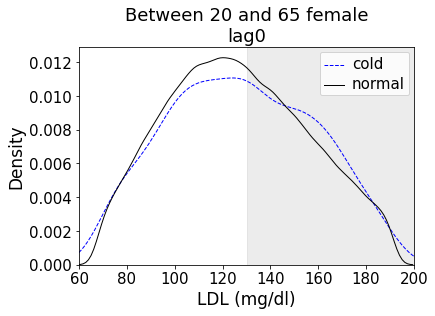

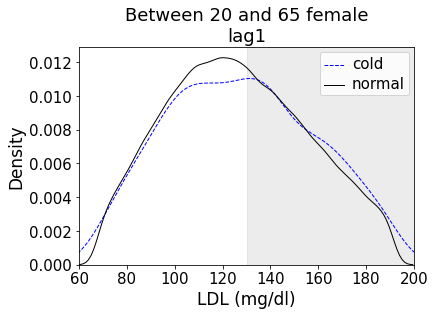

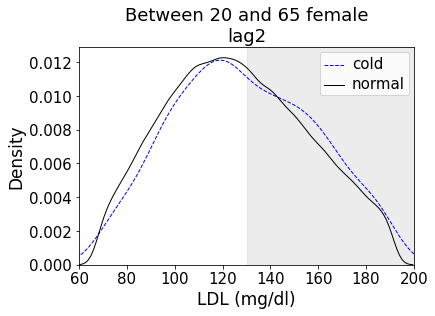

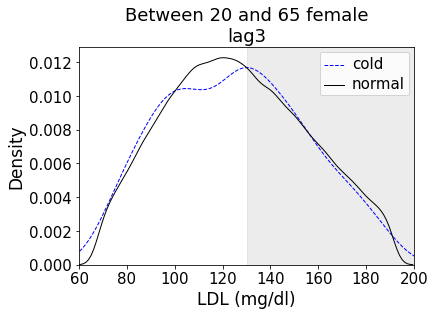

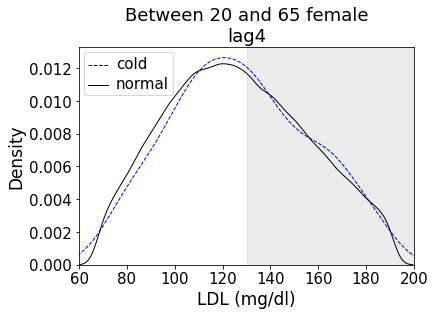

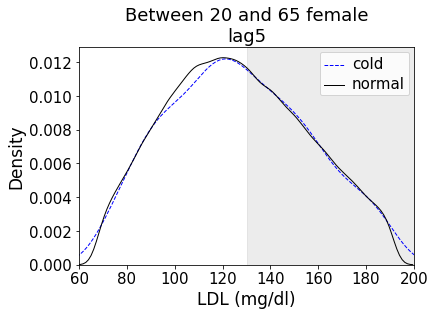

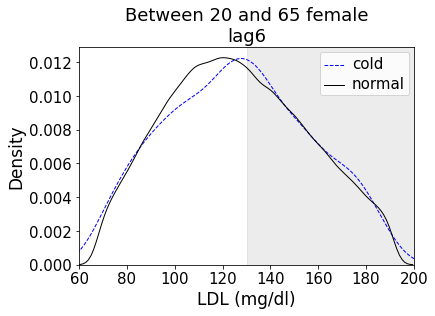

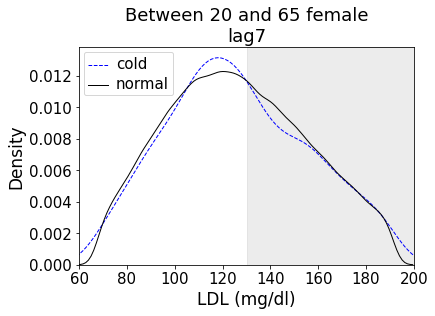

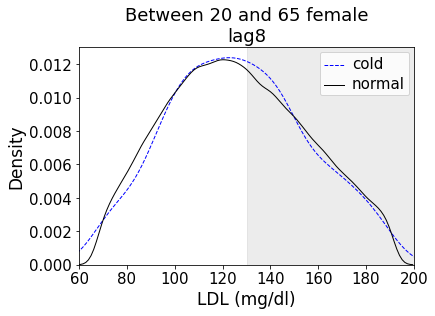

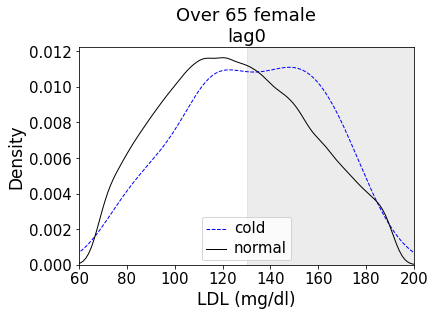

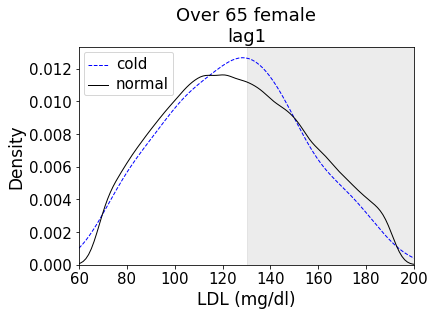

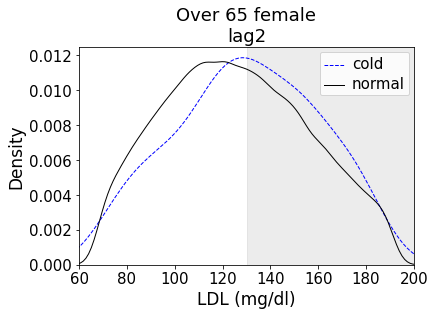

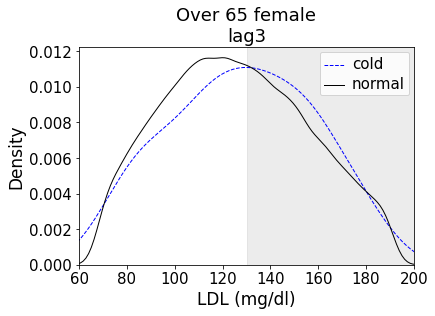

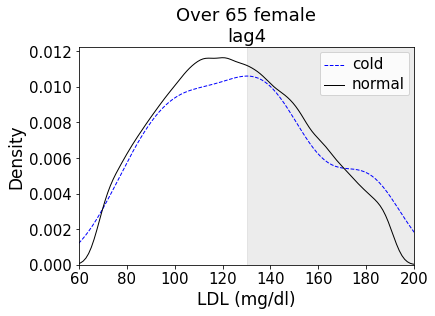

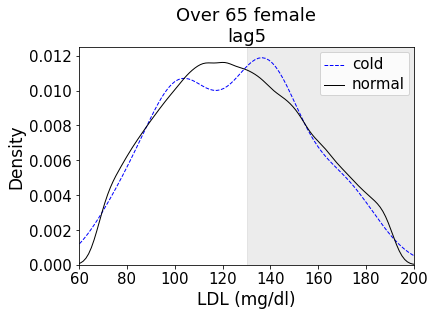

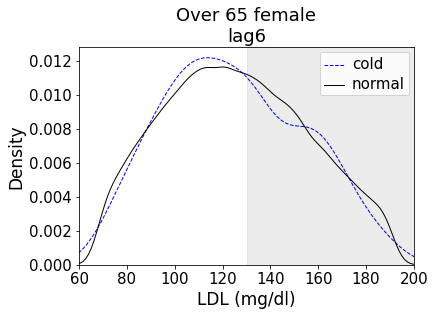

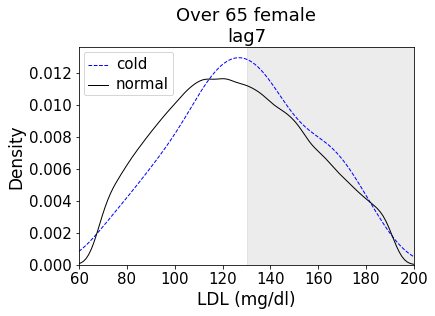

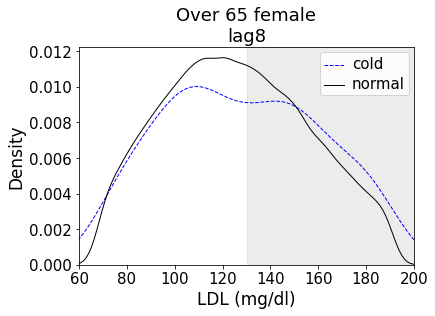

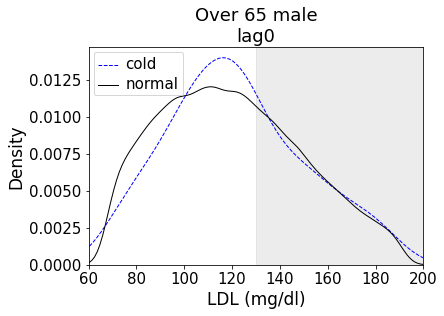

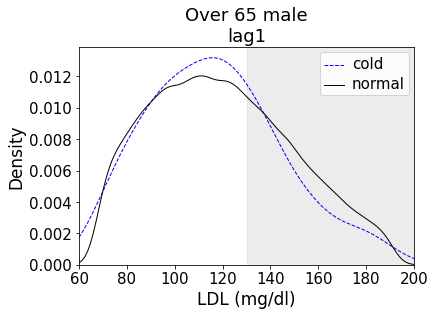

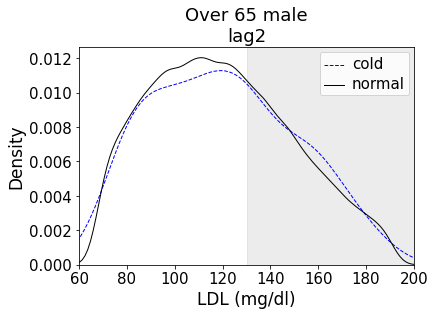

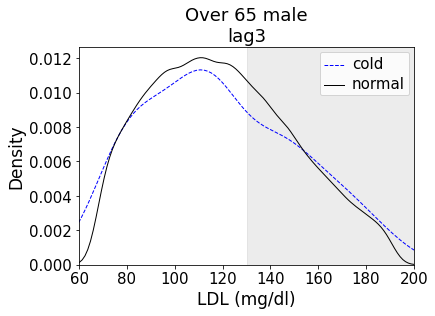

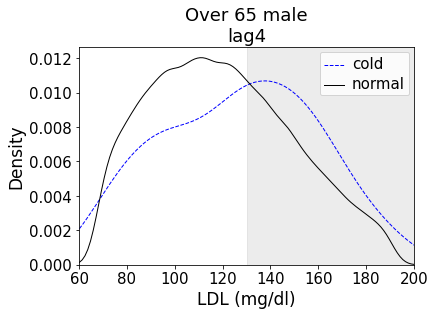

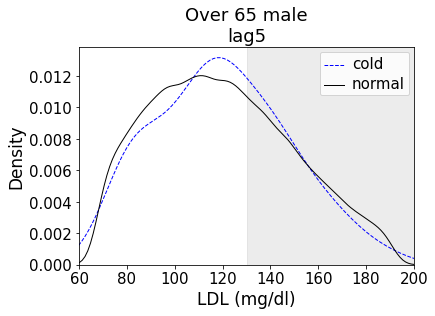

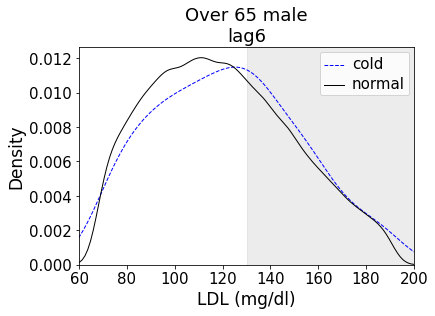

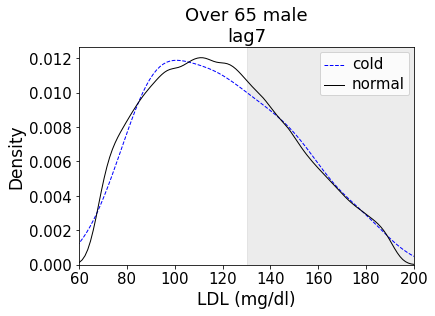

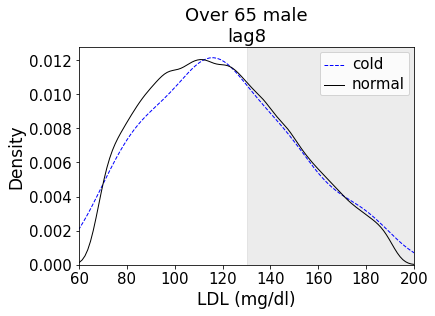

In [10]:
#@title Probability plots for affected groups - (for positive Diff)
#-------------------------------------------------------------------#
#                          Probability                              #
#-------------------------------------------------------------------#
#create subsets
between_20_65_F = df_shift[(df_shift['Age'] >= 20) & (df_shift['Age'] < 65)  & (df_shift['Sex']=="F")]
print("Between 20 and 65 female:",len(between_20_65_F))
over_65_F = df_shift[(df_shift['Age'] > 64) & (df_shift['Sex']=="F")]   
print("Over 65 female:",len(over_65_F))
over_65_M = df_shift[(df_shift['Age'] > 64) & (df_shift['Sex']=="M")]   
print("Over 65 male:",len(over_65_M))                                                                                                                                        

dataframes = [between_20_65_F,over_65_F,over_65_M]
df_names = ["Between 20 and 65 female","Over 65 female", "Over 65 male"]

lags = list(range( 0, 9, 1))
prob = pd.DataFrame()
subset = []
lag = []
cold_spell = []
normal = []
dif = []
mw = []
for j in range(len(dataframes)):
  for i in lags:     
    Cold_1 = pd.Series(dataframes[j]['Result'][dataframes[j][f'CI_lag{i}']==1])
    Normal = pd.Series(dataframes[j]['Result'][(dataframes[j]['cwave']==0)&(dataframes[j]['hwave']==0)&(dataframes[j]['below_pct']==0)&(dataframes[j]['above_pct']==0)])
    b = scipy.stats.mannwhitneyu(Cold_1,Normal,alternative='two-sided')[1]
    ax1 = sns.distplot(Cold_1,hist=False,kde=True,kde_kws = {'linewidth': 1}, label = 'cold',color='blue')
    x1 = ax1.get_lines()[0].get_data()[0] # Get the x data of the distribution
    y1 = ax1.get_lines()[0].get_data()[1] # Get the y data of the distribution
    [line.set_linestyle("--") for line in ax1.lines]
    ax2 = sns.distplot(Normal,hist=False,kde=True,kde_kws = {'linewidth': 1}, label = 'normal',color='black')
    x2 = ax2.get_lines()[1].get_data()[0] # Get the x data of the distribution
    y2 = ax2.get_lines()[1].get_data()[1] # Get the y data of the distribution
    
    '''
    Code for the probability calculus adapted from: https://stackoverflow.com/questions/52470172/how-to-get-possibility-distribution-function-from-python-seaborn-displot
    '''
    #ref value 
    if dataframes[j]['Age'].mean()<=20:
      value = 110

    else:
      value = 130

    #Value to estimate for
    value2 = 200 #x lim
    
    ecart = value2 - value
    idx1 = (np.abs(x1-value)).argmin()
    idx_1 = (np.abs(x1-(value+ecart))).argmin()
    
    idx2 = (np.abs(x2-value)).argmin()
    idx_2 = (np.abs(x2-(value+ecart))).argmin()
      

    cdf1 = scipy.integrate.cumtrapz(y1, x1, dx=1, initial=0)
    pr1 = cdf1[idx_1] - cdf1[idx1] 
    
    cdf2 = scipy.integrate.cumtrapz(y2, x2, dx=1, initial=0)
    pr2 = cdf2[idx_2] - cdf2[idx2] 
    
    plt.xlim(60,200)
    
    plt.xlabel('LDL (mg/dl)',fontsize=17)
    plt.ylabel('Density',fontsize = 17)
    plt.title(f'{df_names[j]}\nlag{i}',fontsize=18)
    ax1.tick_params(labelsize=15)
    plt.setp(ax1.get_legend().get_texts(), fontsize='15')
    plt.axvspan(xmin=(value+0.1), xmax=200,alpha = 0.15,color ='gray')
    
    plt.show()